In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Computing spectral radius...
done.
MSE = 1.0226304109139635e-06


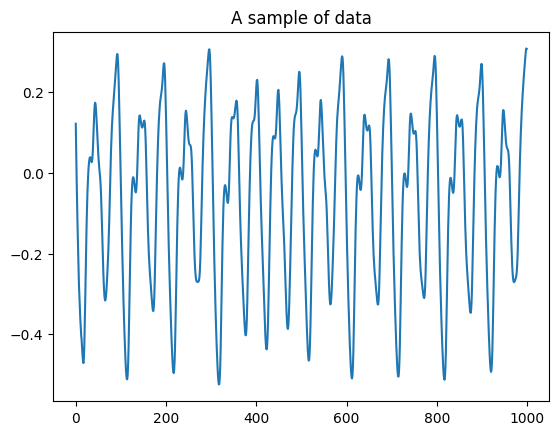

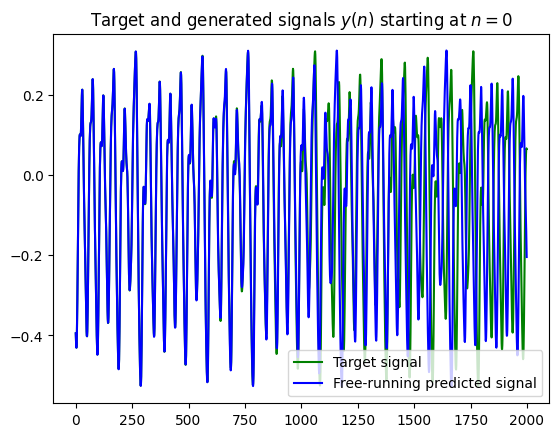

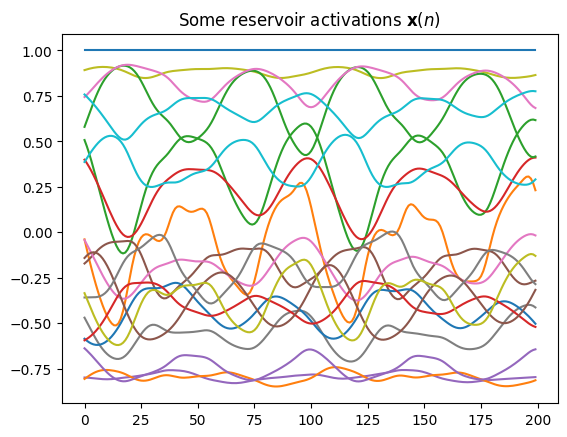

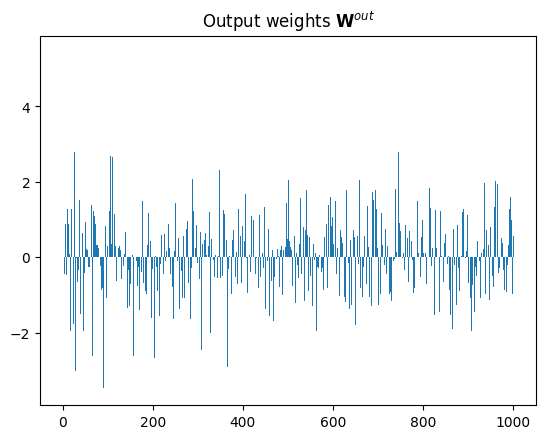

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
# numpy.linalg is also an option for even fewer dependencies

# load the data
trainLen = 2000
testLen = 2000
initLen = 100
data = np.loadtxt('/content/drive/MyDrive/CodeData/Code/GitHub_Examples/BXAI_ESN_Minimal_MackeyGlass_t17.txt')

# plot some of it
plt.figure(10).clear()
plt.plot(data[:1000])
plt.title('A sample of data')

# generate the ESN reservoir
inSize = outSize = 1
resSize = 1000
a = 0.3 # leaking rate
np.random.seed(42)
Win = (np.random.rand(resSize,1+inSize) - 0.5) * 1
W = np.random.rand(resSize,resSize) - 0.5
# normalizing and setting spectral radius (correct, slow):
print('Computing spectral radius...')
rhoW = max(abs(linalg.eig(W)[0]))
print('done.')
W *= 1.25 / rhoW

# allocated memory for the design (collected states) matrix
X = np.zeros((1+inSize+resSize,trainLen-initLen))
# set the corresponding target matrix directly
Yt = data[None,initLen+1:trainLen+1]

# run the reservoir with the data and collect X
x = np.zeros((resSize,1))
for t in range(trainLen):
    u = data[t]
    x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
    if t >= initLen:
        X[:,t-initLen] = np.vstack((1,u,x))[:,0]

# train the output by ridge regression
reg = 1e-8  # regularization coefficient
# direct equations from texts:
#X_T = X.T
#Wout = np.dot( np.dot(Yt,X_T), linalg.inv( np.dot(X,X_T) + \
#    reg*np.eye(1+inSize+resSize) ) )
# using scipy.linalg.solve:
Wout = linalg.solve( np.dot(X,X.T) + reg*np.eye(1+inSize+resSize),
    np.dot(X,Yt.T) ).T

# run the trained ESN in a generative mode. no need to initialize here,
# because x is initialized with training data and we continue from there.
Y = np.zeros((outSize,testLen))
u = data[trainLen]
for t in range(testLen):
    x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
    y = np.dot( Wout, np.vstack((1,u,x)) )
    Y[:,t] = y
    # generative mode:
    u = y
    ## this would be a predictive mode:
    #u = data[trainLen+t+1]

# compute MSE for the first errorLen time steps
errorLen = 500
mse = sum( np.square( data[trainLen+1:trainLen+errorLen+1] -
    Y[0,0:errorLen] ) ) / errorLen
print('MSE = ' + str( mse ))

# plot some signals
plt.figure(1).clear()
plt.plot( data[trainLen+1:trainLen+testLen+1], 'g' )
plt.plot( Y.T, 'b' )
plt.title('Target and generated signals $y(n)$ starting at $n=0$')
plt.legend(['Target signal', 'Free-running predicted signal'])

plt.figure(2).clear()
plt.plot( X[0:20,0:200].T )
plt.title(r'Some reservoir activations $\mathbf{x}(n)$')

plt.figure(3).clear()
plt.bar( np.arange(1+inSize+resSize), Wout[0].T )
plt.title(r'Output weights $\mathbf{W}^{out}$')

plt.show()


MATLAB Code


```
% A minimalistic sparse Echo State Networks demo with Mackey-Glass (delay 17) data
% in "plain" Matlab/Octave.
% from https://mantas.info/code/simple_esn/
% (c) 2012-2020 Mantas Lukosevicius
% Distributed under MIT license https://opensource.org/licenses/MIT

% load the data
trainLen = 2000;
testLen = 2000;
initLen = 100;
data = load('ESN_Minimal_MackeyGlass_t17.txt');

% plot some of it
figure(10);
plot(data(1:1000));
title('A sample of data');

% generate the ESN reservoir
inSize = 1; outSize = 1;
resSize = 1000;
a = 0.3; % leaking rate
rand( 'seed', 42 );
Win = (rand(resSize,1+inSize)-0.5) .* 1;
% dense W:
W = rand(resSize,resSize)-0.5;
% sparse W:
% W = sprand(resSize,resSize,0.01);
% W_mask = (W~=0);
% W(W_mask) = (W(W_mask)-0.5);

% normalizing and setting spectral radius
disp 'Computing spectral radius...';
opt.disp = 0;
rhoW = abs(eigs(W,1,'LM',opt));
disp 'done.'
W = W .* (1.25 / rhoW);

% allocated memory for the design (collected states) matrix
X = zeros(1+inSize+resSize,trainLen-initLen);
% set the corresponding target matrix directly
Yt = data(initLen+2:trainLen+1)';

% run the reservoir with the data and collect X
x = zeros(resSize,1);
for t = 1:trainLen
	u = data(t);
	x = (1-a)*x + a*tanh( Win*[1;u] + W*x );
	if t > initLen
		X(:,t-initLen) = [1;u;x];
	end
end

% train the output by ridge regression
reg = 1e-8;  % regularization coefficient
% direct equations from texts:
%X_T = X';
%Wout = Yt*X_T * inv(X*X_T + reg*eye(1+inSize+resSize));
% using Matlab mldivide solver:
Wout = ((X*X' + reg*eye(1+inSize+resSize)) \ (X*Yt'))';

% run the trained ESN in a generative mode. no need to initialize here,
% because x is initialized with training data and we continue from there.
Y = zeros(outSize, testLen);
u = data(trainLen+1);
for t = 1:testLen
	x = (1-a)*x + a*tanh( Win*[1;u] + W*x );
	y = Wout*[1;u;x];
	Y(:,t) = y;
	% generative mode:
	u = y;
	% this would be a predictive mode:
	%u = data(trainLen+t+1);
end

% compute MSE for the first errorLen time steps
errorLen = 500;
mse = sum((data(trainLen+2:trainLen+errorLen+1)'-Y(1,1:errorLen)).^2)./errorLen;
disp( ['MSE = ', num2str( mse )] );

% plot some signals
figure(1);
plot( data(trainLen+2:trainLen+testLen+1), 'color', [0,0.75,0] );
hold on;
plot( Y', 'b' );
hold off;
axis tight;
title('Target and generated signals y(n) starting at n=0');
legend('Target signal', 'Free-running predicted signal');

figure(2);
plot( X(1:20,1:200)' );
title('Some reservoir activations x(n)');

figure(3);
bar( Wout' )
title('Output weights W^{out}');
```

